In [1]:
%pylab qt5

Populating the interactive namespace from numpy and matplotlib


In [71]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import drivers
from importlib import reload
from lib import data_management as dm
from lib.ResonatorDetector import detect_resonator

In [3]:
from datetime import datetime as dt

In [4]:
from drivers.Agilent_PNA_L import *
from drivers.Agilent_EXA import *
from drivers.KeysightAWG import *
from drivers.Keysight_DSOX2014 import *
from drivers.E8257D import MXG, EXG
from drivers.Yokogawa_GS200 import Yokogawa_GS210
from scipy.fftpack import fft, fftshift

In [5]:
def format_time_delta(delta):
    hours, remainder = divmod(delta, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '%s h %s m %s s' % (int(hours), int(minutes), round(seconds, 2))

In [6]:
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

In [7]:
current = Yokogawa_GS210("GS210_1")

In [8]:
q_lo = MXG("MXG")

In [9]:
q_awg=KeysightAWG("AWG3")

In [10]:
vna = Agilent_PNA_L("PNA-L2")

In [11]:
ro_awg = KeysightAWG("AWG2")

In [12]:
dso = Keysight_DSOX2014("DSO2014")

In [13]:
if_freq = 50e6

calibrations = (dm.load_IQMX_calibration_database("TEST", -20))
ro_cal = calibrations.get(frozenset(dict(lo_power=0, ssb_power=-50, lo_frequency=6.57e9+if_freq, 
                                      if_frequency=if_freq, waveform_resolution=0.1).items()))
ro_pb = PulseBuilder(ro_cal)

calibrations = (dm.load_IQMX_calibration_database("TESTQ", -6))
q_cal = calibrations.get(frozenset(dict(lo_power=15, ssb_power=-33, lo_frequency=9.2e9+if_freq, 
                                      if_frequency=if_freq, waveform_resolution=0.1).items()))
q_pb = PulseBuilder(q_cal)

### Check mixers

In [14]:
vna.set_power(0)
vna.sweep_single()

In [15]:
q_awg.output_pulse_sequence(q_pb.add_dc_pulse(1000, 5).build())
ro_awg.output_pulse_sequence(ro_pb.add_dc_pulse(1000, 5).build())

In [16]:
q_awg.output_pulse_sequence(q_pb.add_zero_pulse(1000).build())
ro_awg.output_pulse_sequence(ro_pb.add_zero_pulse(1000).build())

# Qubit setup

In [17]:
current.set_current(.2625e-3)
current.set_status(1)

True

# Continuous measurement with VNA

In [18]:
ro_awg.output_continuous_wave(0,0,0,5, channel=1)
ro_awg.output_continuous_wave(0,0,0,5, channel=2)

In [19]:
vna.set_nop(1001)
vna.set_bandwidth(100)
vna.set_span(10e6)
vna.set_center(6.62e9)
vna.set_bandwidth(100)
vna.set_averages(1)
vna.prepare_for_stb()
vna.sweep_single()
vna.wait_for_stb()
vna.get_all()
res_freq = detect_resonator(vna, "FIT")[0]
res_freq

C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


6621360000.0

In [20]:
vna.set_span(0)
vna.set_center(res_freq)
vna.set_nop(1)

True

## Two-tone spectroscopy (finding the qubit again)

Open the qubit's IQ mixer:

In [21]:
q_awg.output_continuous_wave(0,0,0, 5, channel=1)
q_awg.output_continuous_wave(0,0,0, 5, channel=2)
q_lo.set_output_state("ON")
q_lo.set_power(15)

Make a sweep of the second tone near the qubit transition:

In [22]:
q_freq = 9.17e9
q_span = 110e6
q_lo_freqs = linspace(q_freq-q_span/2, q_freq+q_span/2, 100)
vna.set_bandwidth(2)
vna.set_power(0)

True

In [23]:
z_data = []
for idx, freq in enumerate(q_lo_freqs):
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
    q_lo.set_frequency(freq)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])
z_data = array(z_data)

100.0%

In [24]:
plt.plot(q_lo_freqs, angle(z_data))
q_lo_freqs[angle(z_data)==max(angle(z_data))]

array([  9.15722222e+09])

# Two-tone spectroscopy with pulsed readout 

In [48]:
ro_pb.add_zero_pulse(1).add_dc_pulse(1000, 5)
ro_awg.output_pulse_sequence(ro_pb.build())

q_pb.add_dc_pulse(5000, 5)
q_awg.output_pulse_sequence(q_pb.build())

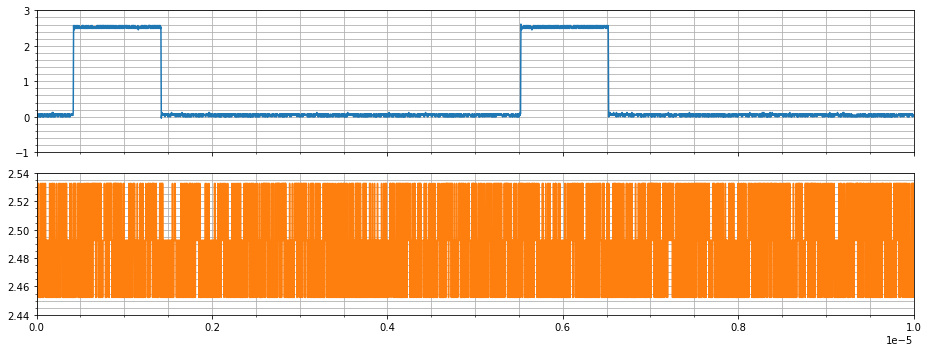

In [49]:
dso.set_time_range(10e-6)
dso.set_time_offset(1e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [220]:
vna.set_averages(10)

True

In [50]:
z_data = []
for idx, freq in enumerate(q_lo_freqs):
    q_lo.set_frequency(freq)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
z_data = array(z_data)

100.0%

array([  9.16388889e+09])

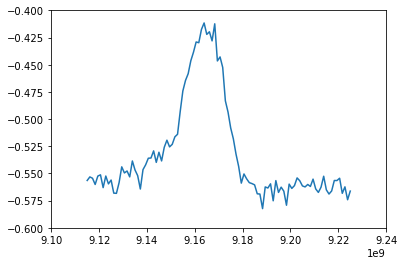

In [51]:
plt.plot(q_lo_freqs, angle(z_data))
q_lo_freqs[angle(z_data)==max(angle(z_data))]

# Two-tone spectroscopy with pulsed readout and excitation

In [25]:
ro_pb.add_zero_pulse(4000-400).add_dc_pulse(1000, 5).add_zero_pulse(200)
ro_awg.output_pulse_sequence(ro_pb.build())

q_pb.add_dc_pulse(3900, 5).add_zero_pulse(1200)
q_awg.output_pulse_sequence(q_pb.build())

In [26]:
dso.set_time_range(10e-6)
dso.set_time_offset(1e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [27]:
z_data = []
for idx, freq in enumerate(q_lo_freqs):
    q_lo.set_frequency(freq)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
z_data = array(z_data)

100.0%

In [32]:
plt.plot(q_lo_freqs, angle(z_data))
q_lo_freqs[angle(z_data)==max(angle(z_data))]

array([  9.17500000e+09])

# Rabi

#### Test sequence at time t

In [85]:
q_lo.set_output_state("ON")

In [29]:
t=250
q_pb.add_zero_pulse(400).add_dc_pulse(t, 5).add_zero_pulse(1000).add_zero_pulse(10000-1000-t-400)
q_awg.output_pulse_sequence(q_pb.build())

ro_pb.add_zero_pulse(t).add_dc_pulse(1000,5).add_zero_pulse(1)
ro_awg.output_pulse_sequence(ro_pb.build())

In [30]:
dso.set_time_range(10e-6)
dso.set_time_offset(1e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [43]:
q_frequency = 9.1745e9

In [44]:
vna.set_averages(4)

True

In [45]:
excitation_times = linspace(0.1, 200, 200)
excitation_freqs = [q_frequency]#linspace(q_frequency-10e6, q_frequency+10e6, 50)#

start_time = dt.now()
print("Started at", start_time)

rabi_shevrons = []
for i, excitation_freq in enumerate(excitation_freqs):
    q_lo.set_frequency(excitation_freq)
    z_data = []
    for j, t in enumerate(excitation_times):
        
        q_pb.add_zero_pulse(400).add_dc_pulse(t, 5).add_zero_pulse(1000).add_zero_pulse(5000-1000-t-400)
        q_awg.output_pulse_sequence(q_pb.build())

        ro_pb.add_zero_pulse(t).add_dc_pulse(1000,5).add_zero_pulse(1)
        ro_awg.output_pulse_sequence(ro_pb.build())
        vna.avg_clear()
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        z_data.append(mean(vna.get_sdata()))
        
        part_complete = (i*len(excitation_times)+j+1)/len(excitation_times)/len(excitation_freqs)
        elapsed_time = (dt.now() - start_time).total_seconds()
        time_left = format_time_delta(elapsed_time/part_complete-elapsed_time)
        cla()
        plot(excitation_times[:j+1], angle(z_data))
        plt.pause(0.01)
        print("\r%.5f%% Time: %d ns, freq: %.5f GHz. Time left: %s    "%(part_complete*100, t,
                excitation_freq/1e9, time_left), end="")
    rabi_shevrons.append(z_data)
#     pcolormesh(angle(rabi_shevrons).T)
#     plt.pause(0.01)

rabi_shevrons = array(rabi_shevrons)

Started at 2017-04-07 11:02:19.273739


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


100.00000% Time: 200 ns, freq: 9.17450 GHz. Time left: 0 h 0 m 0.0 s     

In [42]:
pcolormesh(excitation_freqs, excitation_times, angle(rabi_shevrons).T-angle(rabi_shevrons[:,0]), cmap="RdBu_r")
# plt.gcf().set_size_inches(15,10)
plt.savefi2g("./data/Apr 7 2017/xmon_al_bmstu_1-I-rabi-shevrons.png")

In [39]:
import pickle

In [41]:
with open("./data/Apr 7 2017/xmon_al_bmstu_1-I-rabi-shevrons.pkl", "w+b") as f:
    pickle.dump((excitation_freqs, excitation_times, angle(rabi_shevrons).T), f)

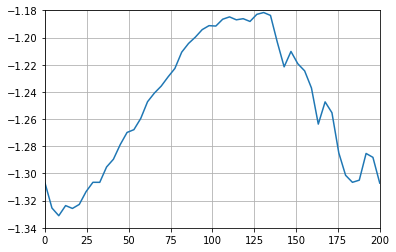

In [241]:
plt.plot(excitatioan_times, angle(rabi_shevrons)[0])
grid()

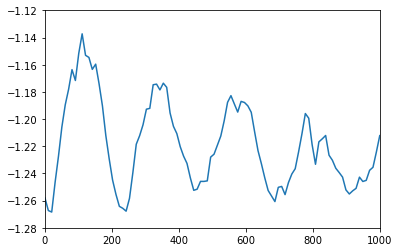

In [105]:
plt.plot(excitation_times, angle(rabi_shevrons)[0])

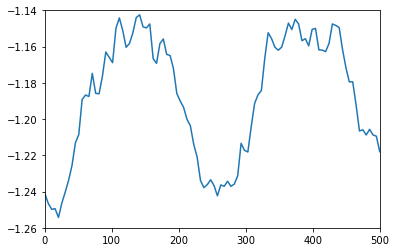

In [127]:
plt.plot(excitation_times, angle(rabi_shevrons)[0])

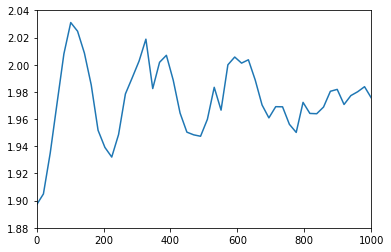

In [48]:
plt.plot(excitation_times, angle(rabi_shevrons)[0])

In [18]:
plt.plot(excitation_times, angle(rabi_shevrons)[0])

# Decay

In [268]:
t_pi = 110

In [269]:
delay = 5000
def generate_pulses(delay):
    q_pb.add_zero_pulse(400).add_dc_pulse(t_pi, 5).add_zero_pulse(1000).add_zero_pulse(10000-1000-t_pi-400)
    q_awg.output_pulse_sequence(q_pb.build())

    ro_pb.add_zero_pulse(t_pi+delay).add_dc_pulse(1000,5).add_zero_pulse(1)
    ro_awg.output_pulse_sequence(ro_pb.build())
generate_pulses(delay)

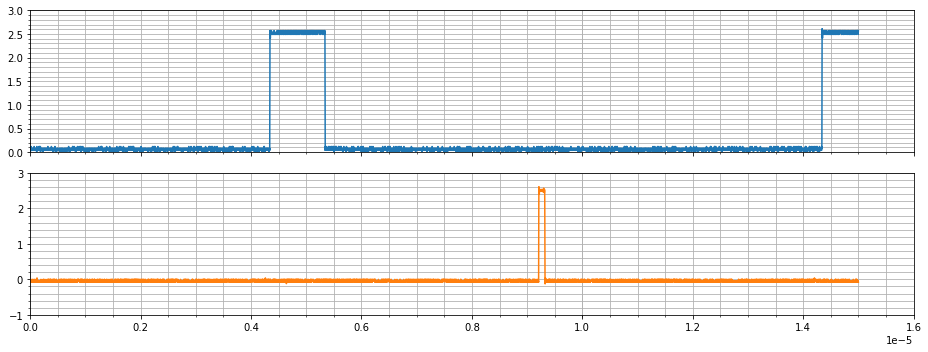

In [270]:
dso.set_time_range(15e-6)
dso.set_time_offset(1.5e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [271]:
vna.set_averages(10)

True

Test phase with no qubit excitation:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


59.00%

KeyboardInterrupt: 

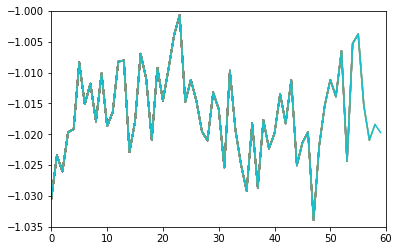

In [280]:
q_lo.set_output_state("OFF")

phases = []
for i in range(0,100):
    vna.avg_clear()
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    phases.append(vna.get_sdata()[0])
    plot(angle(phases))
    pause(0.01)
    print("\r%.2f%%"%(i), end="")
q_lo.set_output_state("ON")

Started at 2017-04-06 18:39:39.133576


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


6.40000% Time: 310 ns, freq: 9.17200 GHz. Time left: 0 h 47 m 16.25 s    

KeyboardInterrupt: 

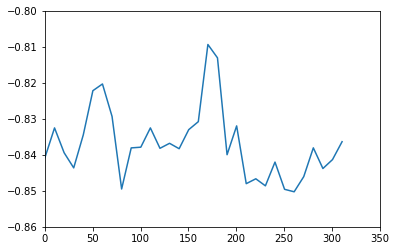

In [282]:
delays = linspace(0, 5000, 500)

start_time = dt.now()
print("Started at", start_time)

z_data = []
for j, delay in enumerate(delays):
    
    generate_pulses(delay)
    
    vna.avg_clear()
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])

    part_complete = (j+1)/len(delays)
    elapsed_time = (dt.now() - start_time).total_seconds()
    time_left = format_time_delta(elapsed_time/part_complete-elapsed_time)
    plt.cla()
    plot(delays[:j+1],angle(z_data))
    plt.pause(0.01)
    print("\r%.5f%% Time: %d ns, freq: %.5f GHz. Time left: %s    "%(part_complete*100, delay,
            excitation_freq/1e9, time_left), end="")

z_data = array(z_data)

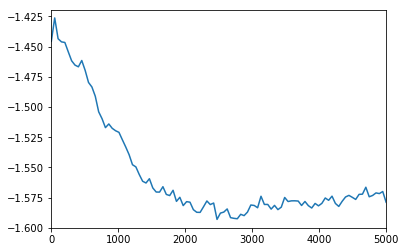

In [254]:
plot(delays, angle(z_data))